In [1]:
pip install -U kaleido

     |████████████████████████████████| 79.9 MB 99.5 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from plotly.subplots import make_subplots
from sklearn.metrics import confusion_matrix,plot_confusion_matrix
import plotly.graph_objects as go
import plotly.figure_factory as ff
from catboost import CatBoostClassifier

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import os
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


![](https://i.imgur.com/8Dwz6mP.png)

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#94D4F6'>1 ❯</span></b> <b>BACKGROUND</b></div>

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>MACHINE LEARNING & VETERINARY SCIENCE</b>

- There are definite parallels between **<span style='color:#94D4F6'>veterinary science</span>** and **<span style='color:#94D4F6'>human medical science</span>**
- Probably due to funding, veterinary science has tended to lack the same degree of ML,DS & AI incorporation as the human medical field
- Even on Kaggle, we can note the large number of medical related competition, but veterinary related ones?
- Despite its absence on Kaggle, there definitely is no shortage of studies that attempt to use tools like a machine learning in order to solve certain problems related to vertinary science, take the study by **[Schofield et al](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8079424/)**, just as one good example & a recent review; **[ML applications in the veterinary field](https://www.researchgate.net/publication/316001269_A_Review_of_Machine_Learning_Applications_in_Veterinary_Field)**
- There is also no shortage of experts in the veterinary field (**[@avma article](https://www.avma.org/javma-news/2020-07-15/artificial-intelligence-veterinary-medicine)**) that praise and encourage the use of ML/AI in the field, but clinics aren't exactly in a rush to integrate DS & ML engineers, mostly only in places where there is substantial funding.
- Another obvious problem arises as well; where to get data? There obviously isn't a strong desire to release clinical data publically, yet there is a lot of commonality between the two fields: take **[ultrasound imaging](https://www.sciencedirect.com/science/article/pii/S2095809918301887)** for example, veterinary related analyses also utilise ultrasound machines. The **[dataset](https://www.kaggle.com/shtrausslearning/feline-pregnancy)** used in this notebook, is a summation of different journals that from which the data has been nicely assembled at published on **[@data.mendeley](https://data.mendeley.com/datasets/h8mcfz95bf/2)**, so that's one place we can access data.
- Veterinary science & Machine learning is definitely an exciting field, especially if you love animals & just to fit the theme, here we'll be looking at a **classification machine learning problem** using the **<span style='color:#94D4F6'>CatBoost</span>** classifier

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>APPLICATION IN REPRODUCTOLOGY</b>

- This notebook is about **<span style='color:#94D4F6'>feline reproductology</span>**, as a good friend of mine works as one, and hence I wanted to understand the topic a little better for myself
- The job of **<span style='color:#94D4F6'>reproductologists</span>** is mainly to guide & ensure safe delivery of offspring. Felines, just like humans go through similar processes, so that's what we'll look at here.

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>PREGNANCY DIAGNOSIS</b>

Main methods for pregnancy diagnosis:
> - Ultrasound imaging (most common method for domestic cats)
> - <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Longitudinal Endocrine Assessments</mark> (progestins, prostaglandins, relaxin) (most common method overall)
> - <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Fecal Protein Assessments</mark> (hormone assessments for non-domestic cats)
> - Vaginal Crytology
> - Laparoscopy

<mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Outlined approaches</mark> are relevant to the dataset used in this notebook & we'll actually be looking at ways to combine information from both, and do some classification


### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>PHASES OF AN ESTROUS CYCLE</b>

The article **[Estrous Cycle](https://en.wikipedia.org/wiki/Estrous_cycle)** outlines four main phases of the estrous cycle:
> - **<span style='color:#94D4F6'>Proestrus</span>**
> - **<span style='color:#94D4F6'>Estrus</span>**
> - **<span style='color:#94D4F6'>Metestrus/Diestrus</span>**
> - **<span style='color:#94D4F6'>Anestrus/Basal</span>**

- The **[dataset](https://www.kaggle.com/shtrausslearning/feline-pregnancy)** includes reference to three of the four stages: **<span style='color:#94D4F6'>Estrus,Diestrus & Basal</span>** phases 
- This is quite a general division & indeed in this dataset, **diestrus**, is further be divided into two phases:
> - **<span style='color:#94D4F6'>NPLP</span>** (**pseudo-pregnancy**)
> - **<span style='color:#94D4F6'>PLP</span>** (**pregnant**) 
> - Description added in **<span style='color:#94D4F6'>Section 2.2</span>** about the differences between the two

Another reference that outlines the behavioural phases as well | Recreated from **[Amanda Petersen PhD](https://stud.epsilon.slu.se/7921/11/petersen_a_150508.pdf)** shows the order of the **<span style='color:#94D4F6'>estrous cycle</span>**

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>ESTROUS CYCLE RELATED HORMONES</b>

- The dataset makes reference to two hormones; **<span style='color:#94D4F6'>estradiol</span>** & **<span style='color:#94D4F6'>progesterone</span>**, which are both reproductive hormones
- Despite the human reproduction related description, their properties shouldn't really change for animals, although the human & animal pregnancy does have its differences
- Of the two hormones, I am led to believe that measurement of **<span style='color:#94D4F6'>progesterone</span>** levels instead of **<span style='color:#94D4F6'>estradiol</span>** are quite popular in veterinarian clinics

#### **<span style='color:#94D4F6'> </span><span style='color:#94D4F6'>ESTRADIOL</span>**

**[Estradiol](https://pubchem.ncbi.nlm.nih.gov/compound/Estradiol) (PubChem NCBI)** | Snipplet from **[Endocrine.org](https://www.endocrine.org/patient-engagement/endocrine-library/hormones-and-endocrine-function/reproductive-hormones)** about estradiol in humans:

> Also called Oestradiol (E2) is the strongest of the three estrogens and an important player in the female reproductive system and the most common type for women of childbearing age. While men and women have estradiol, and it has a role in both of their bodies, women have much higher levels of the hormone than men.

> Estradiol has several functions in the female body. Its main function is to mature and then maintain the reproductive system. During the menstrual cycle, increased estradiol levels cause the maturation and release of the egg, as well as the thickening of the uterus lining to allow a fertilized egg to implant. The hormone is made primarily in the ovaries, so levels decline as women age and decrease significantly during menopause. In men, proper estradiol levels help with bone maintenance, nitric oxide production, and brain function. While men need lower levels than women, they still require this important hormone to function well.

#### **<span style='color:#94D4F6'> </span><span style='color:#94D4F6'>PROGESTERONE</span>**

**[Progesterone](https://pubchem.ncbi.nlm.nih.gov/compound/Progesterone) (PubChem NCBI)** | Snipplet from **[Endocrine.org](https://www.endocrine.org/patient-engagement/endocrine-library/hormones-and-endocrine-function/reproductive-hormones)** about progesterone in humans:

> Progesterone is a steroid hormone belonging to a class of hormones called progestogens. It is secreted by the corpus luteum, a temporary endocrine gland that the female body produces after ovulation during the second half of the menstrual cycle.

> Progesterone prepares the endometrium for the potential of pregnancy after ovulation. It triggers the lining to thicken to accept a fertilized egg. It also prohibits the muscle contractions in the uterus that would cause the body to reject an egg. While the body is producing high levels of progesterone, the body will not ovulate. If the woman does not become pregnant, the corpus luteum breaks down, lowering the progesterone levels in the body. This change sparks menstruation. If the body does conceive, progesterone continues to stimulate the body to provide the blood vessels in the endometrium that will feed the growing fetus. The hormone also prepares the limit of the uterus further so it can accept the fertilized egg. Once the placenta develops, it also begins to secrete progesterone, supporting the corpus luteum. This causes the levels to remain elevated throughout the pregnancy, so the body does not produce more eggs. It also helps prepare the breasts for milk production.


### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>MONITORING HORMONE LEVELS</b>

Two methods of testing **<span style='color:#94D4F6'>estradiol</span>** & **<span style='color:#94D4F6'>progesterone</span>** levels in felines are used in the dataset:

#### **<span style='color:#94D4F6'> </span><span style='color:#94D4F6'>ENDOCRINE MONITORING</span>**

**[Endocrine Tests @Topdoctors.co.uk](https://www.topdoctors.co.uk/medical-dictionary/endocrine-test)**

> ... In many cases, <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">urine</mark> and <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">bloods tests</mark> are used to <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">check your hormone levels</mark>, in some cases, Imaging tests are done to pinpoint or locate a tumor or other abnormalities that may be affecting the endocrine glands.

- More invasive approach than **<span style='color:#94D4F6'>fecal protein assessment</span>**, so is commonly used for domesticated felines

**<span style='color:#94D4F6'>Elevated levels during pregnancy</span>**

- Common & quite straighforward method for diagnosing pregnancy in most mammals;
> - <b>detection of elevated <span style='color:#94D4F6'>circulating progesterone</span> & <span style='color:#94D4F6'>FPM concentrations</span></b>
- In felids, <b><span style='color:#94D4F6'>circulating progesterone</span> & <span style='color:#94D4F6'>FPM</b> are <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">highly elevated during pregnancy</mark>, although <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">peak concentrations vary significantly between different species.</mark>
    
**<span style='color:#94D4F6'>NPLP & PLP Distinguishibility Difficulty</span>**
    
- The use of **<span style='color:#94D4F6'>progesterone</span>** or **<span style='color:#94D4F6'>FPM concentrations</span>** for detecting pregnancy is possible but <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">complicated by the potential for prolonged non-pregnant luteal phases (NPLP)</mark>
- **<span style='color:#94D4F6'>Progesterone levels</span>** are <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">similar during both NPLP and pregnant luteal phases (PLP)</mark>
> - Meaning that **NPLP** & **PLP** cannot be distinguished using **progesterone** or **FPM assessments alone**
- **<span style='color:#94D4F6'>NPLP are approx half the duration of PLP for most felids</span>**, thus <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">pregnancy can be confirmed by detecting elevated progesterone or FPM concentrations during the later half of gestation</mark>
- Neither circulating progesterone or FPM concentrations can be used for pregnancy detection in Lynx:
> - Due to the fact that they exhibit an abnormally long **<span style='color:#94D4F6'>NPLP</span>** and **<span style='color:#94D4F6'>PLP</span>**, with CL persisting for at least two years
- Progesterone based assessments further complicated by:
> - The potential for temporary  mid-gestational decreases in progesterone concentrations, which are thought to be associated with a switch from luteal to placemental progestone productions, leading to false-negative pregnancy diagnoses
    
#### **<span style='color:#94D4F6'> </span><span style='color:#94D4F6'>FECAL PROTEIN ASSESSMENTS</span>**

- In felids, **<span style='color:#94D4F6'>estradiol</span>** & **<span style='color:#94D4F6'>progesterone metabolities</span>** are almost exclusively excreted **through feces**
- **<span style='color:#94D4F6'>FEM</span>**, **<span style='color:#94D4F6'>FPM</span>** are indirect and noninvasive means of monitoring blood concentrations of these hormones
- Fecal **<span style='color:#94D4F6'>estrogens</span>** and **<span style='color:#94D4F6'>progestins</span>** tend to fluctuate less than circulating estradiol & progesterone
- However extraction of progesterone and estradiol is much slower compared to endocrine tests, nevertheless it's still a method commonly used for wild felines

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>MACHINE LEARNING APPLICATION</b>

**<span style='color:#94D4F6'>The Complex Nature of Hormonal Changes</span>**
    
- Female felines, just like women go through maternal cycles, during which the body adapts to changes & hormone levels constantly fluctuate 
- The idea here is to use **<span style='color:#94D4F6'>hormone measurement data</span>** that have already been classified by humans, and **<span style='color:#94D4F6'>build a unified model</span>** that can classify at which phase of the cycle the feline of interest is at the moment of testing, whatever the testing method.
- This in itself is a very complex task, as felines can have very different homonal backgrounds/profiles, and not to even mention the subtle variation of changes that can occur as a result of attempting to obtain the samples in the first place (when doing evasive type testing)
- As mentioned above, there is also **<span style='color:#94D4F6'>difficulty in distinguishing between NPLP and PLP phases</span>**, which both occur during the diestrus phase:
> - NPLP, as the name implies is not at a **pregnant** phase yet, 
> - Wheras as **PLP** is as the name suggest the **<span style='color:#94D4F6'>pregnant luteal phase</span>**
    
**<span style='color:#94D4F6'>A Classification Problem</span>**
    
- The article, **Monitoring ovarian function and detecting pregnancy in felids: a review**, from which this dataset was obtained, focused on the need to **develop methodologies for monitoring of estrus and pregnancy in felines**, mostly due to the need for noninvasive testing methods for wild felines
- This isn't the aim of this notebook, but we can utilise the data for the purposes of applying machine learning methods to an interesting application; **<span style='color:#94D4F6'>classification of estrous cycle</span>** based on feline hormonal data (**<span style='color:#94D4F6'>Estradiol</span>** & **<span style='color:#94D4F6'>Progesterone</span>**) or just **<span style='color:#94D4F6'>ovarian phase classification**
    
**<span style='color:#94D4F6'>Notebook Aim</span>**
    
- So the aim is to build a **classification model** that will unify different testing approaches (fem,fpm,serum) and be able to classify correctly based on either **progesterone** or **estradiol** levels, in whichever combination (min,max,mean), at which phase of the estrous cycle the feline is at the moment of testing
- The reason a unified method may be of interest because:
    > - Insufficient data can result in inconsistent models each time it's trained
    > - There should be a correlation between methods (definitely serum & fecal testing)
    > - Any new methodology & subsequent feature extraction can complement one another, taking in more information about the entire process
    
**<span style='color:#94D4F6'>Purpose of such a model</span>**
    
- Such a model can help veterinarians quite rapidly confirm their own diagnosis (through whatever method they were taught to use) or at least be tool to question their own diagnosis. 
- This particular application may not be the most practical as I don't work in the industry, but it serves the purpose outlined below:
> - In essence, we'll aim to show that machine learning models can capture tendencies & relations in data that can be hard to notice to the naked eye, which is why their use can help solve many problems in veterinary science, this is one of many possible applications.
    
### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>RELATED LINKS</b>

    
- **[Female Reproduction @NCBI](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7158189/)**
- **[Proceedings of the British Society of Animal Science](https://www.cambridge.org/core/services/aop-cambridge-core/content/view/1E725FEC9443C13E5F36D90B9A693683/S2040470019000013a.pdf/proceedings_of_the_british_society_of_animal_science.pdf)**
- **[A Review of Machine Learning Applications in Veterinary Field](https://www.researchgate.net/publication/316001269_A_Review_of_Machine_Learning_Applications_in_Veterinary_Field)**
- **[Machine-learning based prediction of Cushing’s syndrome in dogs attending UK primary-care veterinary practice](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8079424/)**

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#94D4F6'>2 ❯</span></b> <b>DATASET FEATURES</b></div>

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>LIST OF FEATURES</b>

The features are divided into <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">two main groups</mark> / **<span style='color:#94D4F6'>four subgroups</span>** of results:

- <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">0-4 : Plasma or serum concentrations</mark>
    - 0-1 : **<span style='color:#94D4F6'>Circulating Estradiol</span>** (pg/ml)
        - 0 : Anoestrus/Interestrus <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Basal</mark>
        - 1 : <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Estrus</mark> (Peak)
    - 2-4 : **<span style='color:#94D4F6'>Circulating Progesterone</span>** (ng/ml)
        - 2 : <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Basal</mark> (i.e. not diestrus) 
        - 3 : Diestrus/luteal phase (Peak) | **Non-pregnant luteal phase** <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">NPLP</mark> 
        - 4 : Diestrus/luteal phase (Peak) | **Pregnant luteal phase** <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">PLP</mark>
        
- <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">5-9 : Fecal metabolites</mark>
    - 5-6 : **<span style='color:#94D4F6'>Fecal estradiol metabolites (FEM)</span>** (ng/g)
        - 5 : Anoestrus or interestrus <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Basal</mark>
        - 6 : <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">Estrus</mark> (Peak)
    - 7-9 : **<span style='color:#94D4F6'>Fecal progesterone metabolites (FPM)</span>** (µg/g)
        - 7 : Basal (i.e. not diestrus)
        - 8 : Diestrus/luteal phase (Peak) | **Non-pregnant luteal phase** <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">NPLP</mark>
        - 9 : Diestrus/luteal phase (Peak) | **Pregnant luteal phase** <mark style="background-color:#94D4F6;color:white;border-radius:5px;opacity:0.9">PLP</mark>
      
      
- For each feature we have 5 features: <code>min</code>, <code>max</code>, <code>mean</code>, <code>number of animals (n)</code> & <code>number of samples (ns)</code>
- So from our data we are dealing with **sets of results** of either **estradiol** or **progesterone** levels of <code>ns</code> animals, from whom the authors of the individual sets of data sampled <code>n</code> times 
      

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>ADDITIONAL DESCRIPTION</b>

Some extracts from references that are relevant to this data:

**<span style='color:#94D4F6'>Luteal Phase</span>**

> - The luteal phase plays an important role in early pregnancy, as it's the time when the womb prepares for the implantation of a fertilized egg
> - The luteal phase lasts from the day after ovulation until the day before your period starts

**<span style='color:#94D4F6'>NPLP & PLP Difference</span>** - **[Jilian M. Fazio PhD](https://www.proquest.com/openview/76c7e70d9f2df655c562794cb1e2cad6/1?pq-origsite=gscholar&cbl=18750&diss=y)**

> - A non-pregnant luteal phase (NPLP) was defined as a rise in progestogens 2.0 SD above baseline for at least fourteen days starting from the first to the last dates above baseline. The end of the luteal phase was defined as a return to baseline for at least six days
> - A pregnant luteal phase (PLP) was an elevation of progestogens 2.0 SD above baseline for greater than or equal to fourteen days that resulted in live or stillbirth

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#94D4F6'>3 ❯</span></b> <b>DATA EXPLORATION</b></div>

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>READ DATA</b>

- The **[feline pregnancy dataset](https://www.kaggle.com/shtrausslearning/feline-pregnancy)** contains column data without explicitly stating what the features are, so having defined them in (**<span style='color:#94D4F6'>Section 2.1</span>**), we can generate short names, so it will be more clear what they actually are as we are working with them.
- Some minor adjustments are also made to replace certain characters as shown below & in some cases "<1" is used, for this case it's assumed to be 0.5.

In [3]:
# read the data
df = pd.read_csv('/kaggle/input/feline-pregnancy/feline_pregnancy.csv',delimiter=';')

# generate names (as csv uses abbreviations)
features = ['e-basal','e-estrus','p-basal','p-nplp','p-plp',
            'fem-basal','fem-estrus','fpm-basal','fpm-nplp','fpm-plp']
stat = ['mean','min','max','n','ns']
new_names = ['linage','species']
for i in features:
    for j in stat:
        new_names.append(i+j) 
        
# change some minor things
df.columns = new_names # set column names to those we generated
df = df.apply(lambda x: x.str.replace(',','.')) 
df = df.apply(lambda x: x.str.replace('~','')) # approximation sign

feline_progest = df
# some data uses <1, so let's approximate it
feline_progest = feline_progest.apply(lambda x: x.str.replace('<1','0.5'))
# convert data to float
feline_progest.iloc[:,2:] = feline_progest.iloc[:,2:].astype('float')

# check if rows are na
# feline_progest['is_na'] = df[df.columns].isnull().apply(lambda x: all(x), axis=1) 
# feline_progest['is_na'].value_counts()

- The dataset contains a combination of features outlined in **<span style='color:#94D4F6'>Section 2.1</span>**, totalling 51 features, which is quite high in comparison to the number of entries:
    > - Features 2-12 are measurements of **<span style='color:#94D4F6'>estradiol</span>** in circulating blood during **<span style='color:#94D4F6'>basal</span>**/**<span style='color:#94D4F6'>estrus</span>** phases
    > - Features 13-27 are measurements of **<span style='color:#94D4F6'>progesterone</span>** in circulating blood during **<span style='color:#94D4F6'>basal</span>**/**<span style='color:#94D4F6'>diestrus</span>** phases 
    > - Features 28-37 are measurements of **<span style='color:#94D4F6'>fecal estradiol metabolites</span>** in feces during **<span style='color:#94D4F6'>basal</span>**/**<span style='color:#94D4F6'>estrus</span>** phases
    > - Features 38-52 are measurements of **<span style='color:#94D4F6'>fecal progesterone metabolites</span>** in feces during **<span style='color:#94D4F6'>basal</span>**/**<span style='color:#94D4F6'>diestrus</span>** phases 
- We have quite a few gaps in our dataset, especially for **circulating blood** data, which indicates that **<span style='color:#94D4F6'>endocrine monitoring</span>** was not done as consistently as **<span style='color:#94D4F6'>fecal protein assessments</span>** and less data was provided by individual authors
- From the first few data points as shown in <code>.head()</code> alone, we can note that we have various combinations of missing data

In [4]:
feline_progest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 52 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   linage          109 non-null    object
 1   species         109 non-null    object
 2   e-basalmean     18 non-null     object
 3   e-basalmin      19 non-null     object
 4   e-basalmax      19 non-null     object
 5   e-basaln        19 non-null     object
 6   e-basalns       18 non-null     object
 7   e-estrusmean    14 non-null     object
 8   e-estrusmin     13 non-null     object
 9   e-estrusmax     13 non-null     object
 10  e-estrusn       16 non-null     object
 11  e-estrusns      15 non-null     object
 12  p-basalmean     27 non-null     object
 13  p-basalmin      20 non-null     object
 14  p-basalmax      20 non-null     object
 15  p-basaln        25 non-null     object
 16  p-basalns       25 non-null     object
 17  p-nplpmean      16 non-null     object
 18  p-nplpmin 

In [5]:
pd.set_option('max_columns', None)
feline_progest.head()

,linage,species,e-basalmean,e-basalmin,e-basalmax,e-basaln,e-basalns,e-estrusmean,e-estrusmin,e-estrusmax,e-estrusn,e-estrusns,p-basalmean,p-basalmin,p-basalmax,p-basaln,p-basalns,p-nplpmean,p-nplpmin,p-nplpmax,p-nplpn,p-nplpns,p-plpmean,p-plpmin,p-plpmax,p-plpn,p-plpns,fem-basalmean,fem-basalmin,fem-basalmax,fem-basaln,fem-basalns,fem-estrusmean,fem-estrusmin,fem-estrusmax,fem-estrusn,fem-estrusns,fpm-basalmean,fpm-basalmin,fpm-basalmax,fpm-basaln,fpm-basalns,fpm-nplpmean,fpm-nplpmin,fpm-nplpmax,fpm-nplpn,fpm-nplpns,fpm-plpmean,fpm-plpmin,fpm-plpmax,fpm-plpn,fpm-plpns
0,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,3.0,3.0,25.8,NaN,NaN,5.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Domestic cat,Domestic cat,8.1,4.3,11.9,4.0,12.0,59.5,46.1,72.9,4.0,13.0,0.5,NaN,NaN,NaN,NaN,24.6,19.0,31.0,4.0,4.0,34.9,29.0,41.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Domestic cat,Domestic cat,11.7,6.9,16.5,39.0,106.0,NaN,50.0,70.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,0.1,0.3,7.0,32.0,17.2,9.0,25.0,7.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,30.9,87.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>MISSING DATA</b>

- This dataset contains measurement data of **<span style='color:#94D4F6'>estradiol</span>** & **<span style='color:#94D4F6'>progesterone</span>** for both serum & fecal, however the entries are quite highly inconsistent and often only contain one or two readings from the combinations (min,max,mean), as mentioned previously.
- As a result, we'll be needing to **<span style='color:#94D4F6'>meld the data</span>** back into the specific phase group (**<span style='color:#94D4F6'>basal,estrus,nplp & plp</span>**), in order to have enough data for creating a model for phase prediction, since that is ultimately our goal in this notebook
- As we can see from the data below, **<span style='color:#94D4F6'>serum</span>** based data sampling tends to have the highest amount of missing data, as opposed to **<span style='color:#94D4F6'>fecal</span>** measurements, for which we have much more consistent data. 

In [6]:
# Function that plots the number of NaN data in the entire dataset
def plot_na(df):
    series1 = df.isna().sum()
    series2 = df.notnull().sum()
    series3 = series1 + series2
    series1.name = 'NaN'
    series3.name = 'All Data'
    fig = go.Figure(data=[px.bar(series1)['data'][0],
                          px.bar(series3)['data'][0]])

    fig.update_layout(template='plotly_white',height=300,
                      font=dict(family='sans-serif',size=12)) 
    fig.update_layout(showlegend=False,title='NaN Distribution in Entire Dataset')
    fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5, opacity=0.4)
    
    fig.show('svg',dpi=300)

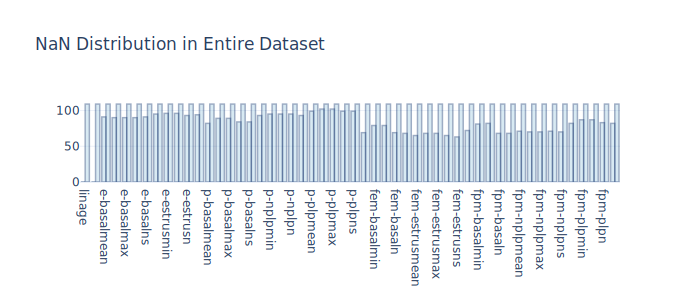

In [7]:
plot_na(feline_progest)

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>SAMPLE SIZES & SPECIES</b>

- The data we are dealing with from **[individual studies](https://data.mendeley.com/datasets/h8mcfz95bf/2/files/749c2aac-10b1-49f5-b0a4-dccdc7ba7f52)** provide **control group statistic**, rather than individual samples (unless of course ns=1, which do exist in the dataset), so what our features indicate are pretty much bounds for each **linage** & **specie** combination & and we can extract the individual samples to some extent (min,max cases for certain)
- Our **mean**, **min** & **max** will have been influenced by the number of samples and animals in each study, however as we don't have individual samples, there seems to be little use for this information
- Visually, we can see/confirm below that there is quite a substatial variation among different **specie** & **linage** combinations

In [8]:
import seaborn as sns; sns.set(style='whitegrid')

''' Plot Verticle Heatmap using Plotly '''
def plotlyoff_heatmap(hm,size=None):    
    fig,ax = plt.subplots(ncols=2,figsize=(15,7),)
    sns.heatmap(hm[0],ax=ax[0],annot=False)
    sns.heatmap(hm[1],ax=ax[1],annot=False)
    ax[0].set_title("Number of Felines")
    ax[1].set_title("Number of Samples")
    plt.tight_layout()
    plt.show()

In [9]:
sample_sizes = feline_progest[['linage','species','e-basaln','e-basalns','e-estrusn',
                               'e-estrusns','p-basaln','p-basalns','p-plpn','p-plpns',
                               'p-nplpn','p-nplpns','fem-basaln','fem-basalns',
                               'fem-estrusn','fem-estrusns','fpm-basaln','fpm-basalns',
                               'fpm-nplpn','fpm-nplpns','fpm-plpn','fpm-plpns']]

# sample_sizes.groupby('species').max()
pt = pd.pivot_table(sample_sizes,index=['species','linage'])
pt.index=pt.index.get_level_values(0)+"("+pt.index.get_level_values(1)+")" # merge multindex

n_pt = pt.iloc[:,::2] # number of animals
ns_pt = pt[['e-basalns','e-estrusns','p-basalns','p-plpns','p-nplpns',
 'fem-basalns','fem-estrusns','fpm-basalns','fpm-nplpns',
 'fpm-plpn','fpm-plpns']]

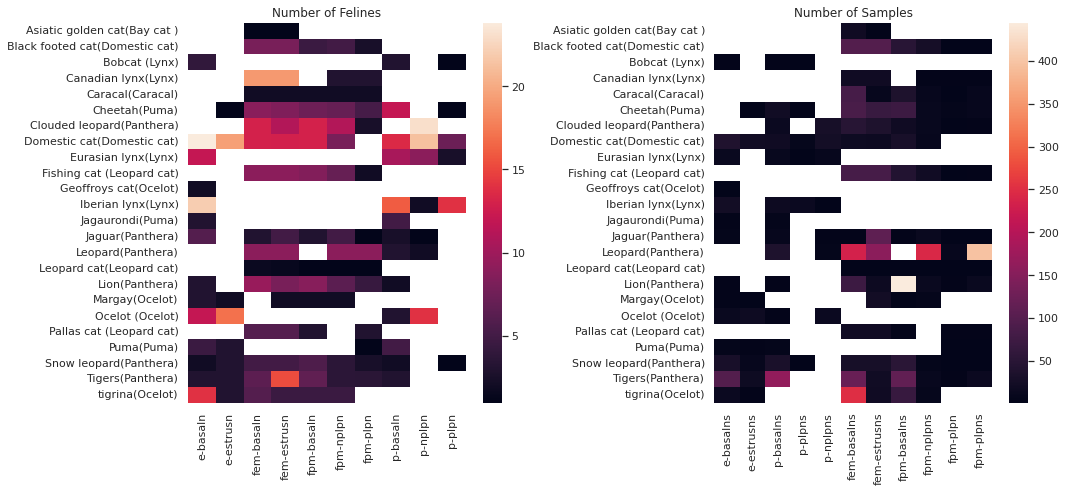

In [10]:
plotlyoff_heatmap([n_pt,ns_pt])

- We'll also drop features relating to **sample size** & **number of animals** in each study (<code>ns</code> & <code>n</code>)
- Although there may be some benefit of including them, however it seems they aren't really necessary in this problem

In [11]:
# Drop Sample number data
feline_progest.drop(['e-basaln','e-basalns','e-estrusn','e-estrusns',
                    'p-basaln','p-basalns','p-plpn','p-plpns','p-nplpn','p-nplpns',
                    'fem-basaln','fem-basalns','fem-estrusn','fem-estrusns',
                     'fpm-basaln','fpm-basalns','fpm-nplpn','fpm-nplpns',
                     'fpm-plpn','fpm-plpns'],axis=1,inplace=True)

In [12]:
# Our premodel dataset
feline_progest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 32 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   linage          109 non-null    object
 1   species         109 non-null    object
 2   e-basalmean     18 non-null     object
 3   e-basalmin      19 non-null     object
 4   e-basalmax      19 non-null     object
 5   e-estrusmean    14 non-null     object
 6   e-estrusmin     13 non-null     object
 7   e-estrusmax     13 non-null     object
 8   p-basalmean     27 non-null     object
 9   p-basalmin      20 non-null     object
 10  p-basalmax      20 non-null     object
 11  p-nplpmean      16 non-null     object
 12  p-nplpmin       14 non-null     object
 13  p-nplpmax       14 non-null     object
 14  p-plpmean       10 non-null     object
 15  p-plpmin        7 non-null      object
 16  p-plpmax        7 non-null      object
 17  fem-basalmean   40 non-null     object
 18  fem-basalm

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>FELINE SPECIE DISTRIBUTION</b>

- The dataset contains **<span style='color:#94D4F6'>estradiol</span>** & **<span style='color:#94D4F6'>progesterone</span>** for not only domesticated felines, but also for non-domesticated cats such as **<span style='color:#94D4F6'>Pantheras, Pumas, Ocelots, Leopard, Lynx, Caracals & Bay Cats</span>**
- So despite the large portion of domestic cats, most of the dataset contains data for wild felines, as shown in the graph below

In [13]:
# function to show value_counts using plotly
def plot_count(df,feature,orie='v',h=400):

    series = df[feature].value_counts()
    fig = px.bar(series,orientation=orie,color='value')
    fig.update_layout(template='plotly_white',height=h,
                      font=dict(family='sans-serif',size=12)) 
    fig.update_layout(showlegend=False)
    fig.update_traces(marker_color='rgb(158,202,225)', 
                      marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5, opacity=0.6)
    fig.update_traces(width=0.75)
    
    fig.show('svg',dpi=300)

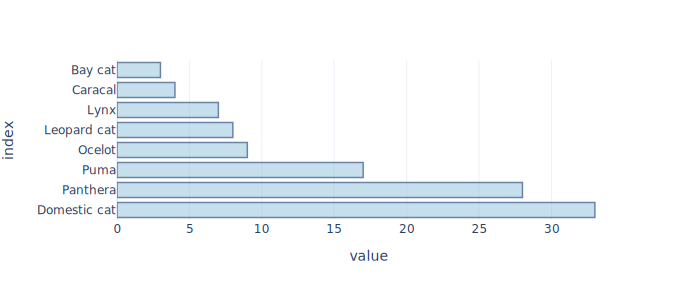

In [14]:
plot_count(feline_progest,'linage',orie='h',h=300)

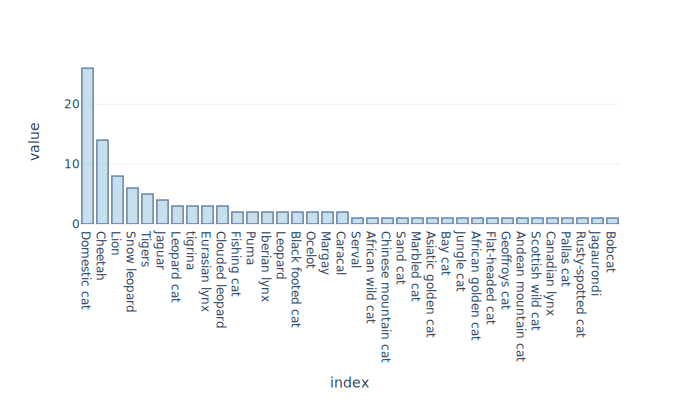

In [15]:
plot_count(feline_progest,'species',orie='v',h=400)

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>ESTRADIOL LEVEL DISTRIBUTION</b>

- Inspecting the **<span style='color:#94D4F6'>estradiol</span>** levels for different **linage** we can note some quite clear tendencies for the **mean** values

> - All felines have increased estradiol levels during **estrus**, which was expected, the only variation that exists is that for different species the levels were quite different
> - The same tendencies were observed for both **serum** and **fecal** data subsets

- The levels for both **maximum** & **minimum** levels of **<span style='color:#94D4F6'>estradiol</span>**:
> - Followed similar trends, however in very few cases, there have been dips in values during **<span style='color:#94D4F6'>estrus</span>** as seen in the **leopard** data
> - Such abnormalities of course can catch the model off guard, as the entire dataset follows an increasing trend

- Another observation can be made about **<span style='color:#94D4F6'>outliers</span>**:
> There are very cases that fall outside the **minimum** & **upper fence** levels, as can be seen some levels of **domesticated felines** are abnormally high



In [16]:
# function to show data distribution using plotly boxplot
def plot_strip(ldf,features,plot_id='box',
               color=None,title=None):
    
    tdf = ldf[features]
    del tdf['species']
    
    if(plot_id is 'box'):
        fig = px.box(tdf,orientation='v',color=color,facet_col=color,
                     color_discrete_sequence= px.colors.sequential.Plasma_r,
                    facet_col_wrap =4)
    elif(plot_id is 'strip'):
        fig = px.strip(tdf,orientation='v',color=color)
        
    fig.update_layout(template='plotly_white',height=700,
                      title=f'{title}',
                      font=dict(family='sans-serif',size=12)) 
    fig.update_traces(width=0.25)
    fig.update_layout(showlegend=False)
    fig.update_traces(marker_color='#056293', marker_line_color='rgb(8,48,107)',
                      marker_line_width=1.5, opacity=0.7)

    fig.show('svg',dpi=300)

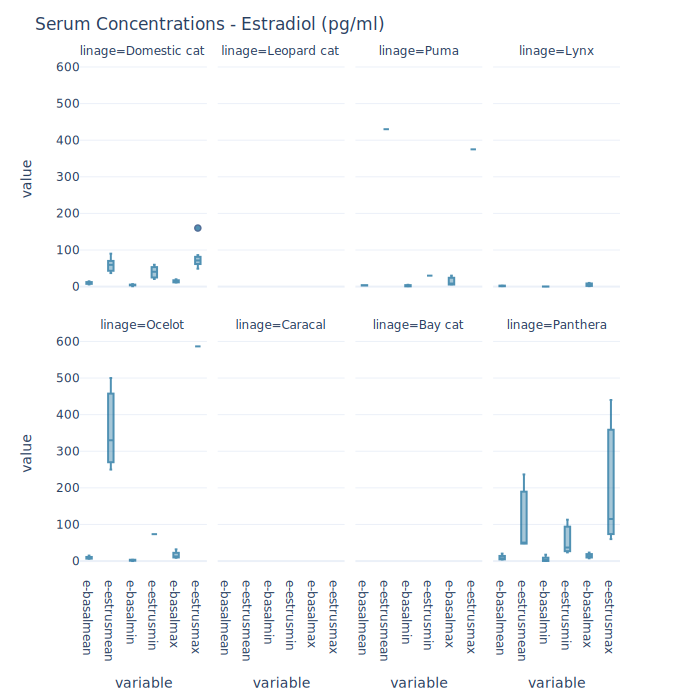

In [17]:
main_lst = feline_progest.columns.tolist()
lst = map(lambda x:main_lst[x],[0,1,
                                2,5,
                                3,6,
                                4,7])
    
plot_strip(feline_progest,lst,'box',
           'linage','Serum Concentrations - Estradiol (pg/ml)')

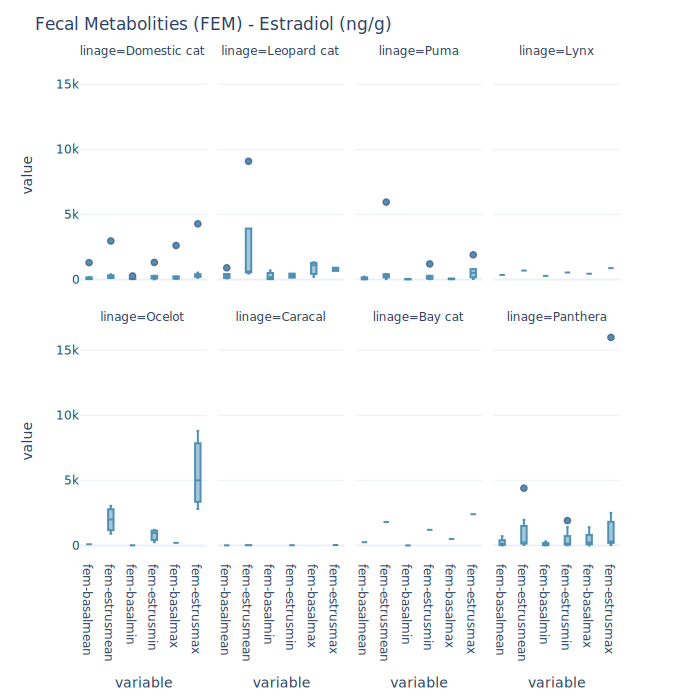

In [18]:
main_lst = feline_progest.columns.tolist()
lst = map(lambda x:main_lst[x],[0,1,
                                17,20,
                                18,21,
                                19,22])
    
plot_strip(feline_progest,lst,'box',
           'linage','Fecal Metabolities (FEM) - Estradiol (ng/g)')

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>PREGESTERONE LEVEL DISTRIBUTION</b>

- Next we'll look at the **<span style='color:#94D4F6'>progesterone</span>** levels, for this hormone subset we have three phases that were recorded; **<span style='color:#94D4F6'>basal</span>** & **<span style='color:#94D4F6'>diestrus</span>** (**nplp**/**plp**), so **<span style='color:#94D4F6'>estrus</span>** was not included
- Like elevated **<span style='color:#94D4F6'>estradiol</span>** levels during **<span style='color:#94D4F6'>estrus</span>**, **<span style='color:#94D4F6'>progesterone</span>** levels are also elevated in post **<span style='color:#94D4F6'>basal</span>** phases (**<span style='color:#94D4F6'>nplp</span>**,**<span style='color:#94D4F6'>plp</span>**)
- Unlike **<span style='color:#94D4F6'>estradiol</span>**, here we have quite a bit more variety when it comes to **plp** & **nplp** levels, for different **linage** variations, looking at the **mean** values:
> - **<span style='color:#94D4F6'>Domesticated felines</span>** tend to have slightly higher levels of **<span style='color:#94D*4F6'>progasterone</span>** during **nplp** than **plp** in **serum**
> - **<span style='color:#94D4F6'>Lynx</span>** on the other hand tend to have higher **<span style='color:#94D4F6'>progasterone</span>** levels during **plp** in **serum** (so the other way round)
> - **<span style='color:#94D4F6'>Panthera</span>** tend to follow the same trend as **<span style='color:#94D4F6'>domesticated felines</span>**

**<span style='color:#94D4F6'>Fecal</span>** data provided some insight into some other linage:
> - **<span style='color:#94D4F6'>leopard cats</span>**, similar to **<span style='color:#94D4F6'>Lynx</span>** have tendencies of having larger **plp** values comared to **nplp**, **<span style='color:#94D4F6'>Puma</span>** also follow this trend
> - It can be noted that the these trend variations are very subtle, both **plp** & **nplp** are not too different
> - This seems to suggest that there can be some difficult to distinguish between these two phases if we were to just look at **progesterone** concentrations alone

- We can also note that we have clear gaps in data for **<span style='color:#94D4F6'>leopard</span>**, **<span style='color:#94D4F6'>caracal</span>** & **<span style='color:#94D4F6'>bay cat</span>** when it comes to **serum** data, only **<span style='color:#94D4F6'>fecal</span>** data was collected

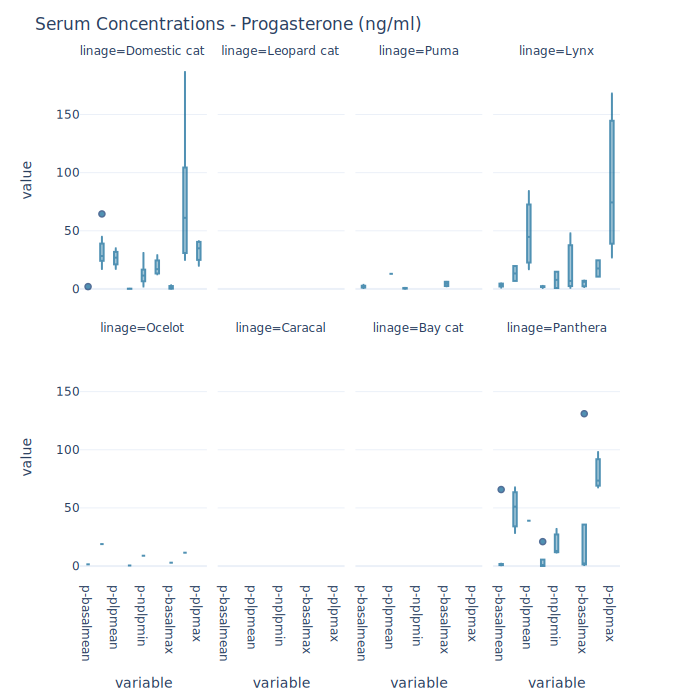

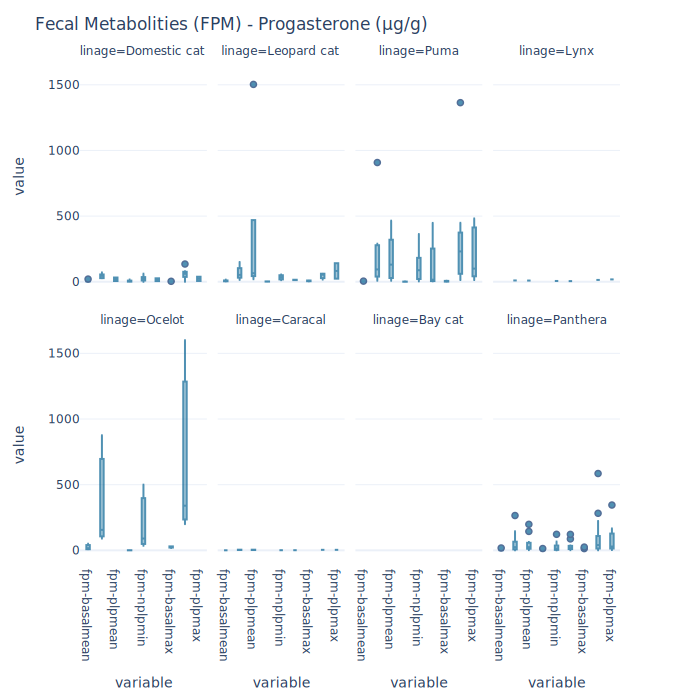

In [19]:
main_lst = feline_progest.columns.tolist()
lst = map(lambda x:main_lst[x],[0,1,
                                8,11,14,
                                9,12,15,
                                10,13,16])
    
plot_strip(feline_progest,lst,'box',
           'linage','Serum Concentrations - Progasterone (ng/ml)')

main_lst = feline_progest.columns.tolist()
lst = map(lambda x:main_lst[x],[0,1,
                                23,26,29,
                                24,27,30,
                                25,28,31])
    
plot_strip(feline_progest,lst,'box',
           'linage','Fecal Metabolities (FPM) - Progasterone (µg/g)')

## <div style="padding: 30px;color:white;margin:0;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#17202a "><b><span style='color:#94D4F6'>4 ❯</span></b> <b>MODELING</b></div>


### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>REARRANGING DATA</b>

Compiling data from different data sources:
  - We are left with a lot of variation in the recorded data, thus have lot's of NaN as available data is not consistent since they are taken from different sources
  - We can have any combination of (min,max,mean), but what we are measuring is the same content; **<span style='color:#94D4F6'>estrus</span>** or **<span style='color:#94D4F6'>progasterone</span>**, from serum or feces.
  - Thus we can simply **meld our data** & divide the data based on the phase it was allocated into; **<span style='color:#94D4F6'>basal</span>** or **<span style='color:#94D4F6'>estrus</span>** ..., the actual phase is in the column name.
  -  The rearranged data is then simply **<span style='color:#94D4F6'>one-hot encoded</span>**, so it's not relevant which measurement (min,max,mean) was recorded

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>LIST OF MODELS</b>

- As mentioned in **<span style='color:#94D4F6'>Section 2.1</span>**, we have two main groups (serum,fecal) & 4 subgroups (serum-e,serum-p,fecal-e,fecal-p) in total
- We'll first look at making models for each subgroup of data & then make combined models of subgroups

**<span style='color:#94D4F6'>Subgroup Models</span>**

> - First model should be straightforward; **<span style='color:#94D4F6'>binary classification</span>** between **basal** & **estrus** phases using **serum** **<span style='color:#94D4F6'>estrous</span>** data
> - Second model should be more challenging; **<span style='color:#94D4F6'>multiclass classification</span>** between **basal** & **diestrus** phases (**nplp**,**plp**) using **serum** **<span style='color:#94D4F6'>progasterone</span>** data
> - Third model should be straightforward; **<span style='color:#94D4F6'>binary classification</span>** between **basal** & **estrus** phases using **fecal** **estrous** data this time
> - Fourth model; **<span style='color:#94D4F6'>multiclass classification</span>** between **basal** & **diestrus** phases (**nplp**,**plp**) again, but this time using **fecal** **progasterone** data as well

**<span style='color:#94D4F6'>Grouped Models</span>**

> - The fifth model; **<span style='color:#94D4F6'>multiclass classification</span>** between all available **basal** & **diestrus**(**nplp**,**plp**) phase **progasterone** data

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>EVALUATION FUNCTION</b>

### <b><span style='color:#94D4F6'>model_eval</span></b>

- As with most of my other notebooks, I like to create a unified evaluation function that can be reused in different problems, but opted with a function for the time being
- <code>model_eval</code> can be used to evaluate the model on a **<span style='color:#94D4F6'>train/test splitting approach</span>**, a little more simpler than for eg. **<span style='color:#94D4F6'>kfold cv</span>** (cv is of course important for any ml problem), which I used in **[another notebook](https://www.kaggle.com/shtrausslearning/cfd-trade-off-study-visualisation-response-model)**
- We'll add **<span style='color:#94D4F6'>kfold cross validation</span>** for the **<span style='color:#94D4F6'>grouped models</span>** as it is a little more viable to split the data into more than two groups & it is definitely desirable to cross validate the models.

<code>model_eval</code> function parameters:
- <code>data</code> : Feature Matrix & Target Variable DataFrame
- <code>ts</code> : Train/Test split ratio
- <code>target</code> : Target Feature in the DataFrame
- <code>clf</code> : Classifier
- <code>clf</code> : Evaluation case name (for unique model save)
- <code>classif_id</code> : Classification Type (could just have automated it)
- <code>show_id</code> : Evaluation options; (conf,roc)

**<span style='color:#94D4F6'>Evaluation Metric</span>**
- We'll be using very standard metrics for both **binary** and **multiclass** classification; The **<span style='color:#94D4F6'>confusion matrix</span>** and **<span style='color:#94D4F6'>ROC</span>** curves
- Plotly is of course my prefered way of plotting things & they recently updated their plot library to include **[ROC & PR Curves](https://plotly.com/python/roc-and-pr-curves/)**, which is quite a helpful reference for ML beginners

In [20]:
# Standard Train/Test Split Validation 
def model_eval(data,  # data input
               ts=0.3, # train/test split ratio
               target = 'id', # target feature 
               clf=None, # model list
               clf_name='model',
               classif_id='binary', # type of classification
               show_id=['roc']): # output options

    # train/test split
    y = data[target]
    X = data.drop(target,axis=1)

    if(clf is not None):
        clf = clf[1]
    # default model if not model is selected
    else:
        clf = RandomForestClassifier(max_depth=10,
                                     random_state=0)
    
    # Train/Test split our dataset
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                        test_size=ts)
    
    # Show the split distribution
    print(f'Training Samples: {X_train.shape[0]}')
    print(f'Test Samples: {X_test.shape[0]}')

    # train model
    clf.fit(X_train,y_train)
    clf.save_model(f"{clf_name}")
    
    # predict on training data & test data
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    # Evaluate Metrics
#     print("Accuracy:",metrics.accuracy_score(y_train, y_pred_train))
#     print("Accuracy:",metrics.accuracy_score(y_test, y_pred_test))
    
    # Plot Confusion Matrix for Training / Test Data
    if('conf' in show_id):
        
        data1 = confusion_matrix(y_train,y_pred_train)
        data2 = confusion_matrix(y_test,y_pred_test)
  
        ''' Plot Verticle Heatmap using Plotly '''
        def plotlyoff_heatmap(hm,size=None):    
            fig,ax = plt.subplots(ncols=2,figsize=(8,4),)
            sns.heatmap(hm[0],ax=ax[0],annot=True)
            sns.heatmap(hm[1],ax=ax[1],annot=True)
            ax[0].set_title("Training Confusion Matrix")
            ax[1].set_title("Test Confusion Matrix")
            plt.tight_layout()
            plt.show()
            
        data1 = pd.DataFrame(data1)
        data1.index = clf.classes_
        data1.columns = clf.classes_
        data2 = pd.DataFrame(data2)
        data2.index = clf.classes_
        data2.columns = clf.classes_
        plotlyoff_heatmap([data1,data2])
        
    
    # Plot ROC Curves for Training / Test Data
    if('roc' in show_id):
        
        fig = make_subplots(rows=1,cols=2,subplot_titles=['Train','Test'])
        
        if(classif_id is 'binary'):

            y_score_train = clf.predict_proba(X_train)[:, 1]
            y_score_test = clf.predict_proba(X_test)[:, 1]

            ii=-1; iii=0
            lst_in_X = [X_train,X_test]
            lst_in_y = [y_train,y_test]
            lst_subgroup = [y_score_train,y_score_test]
            lst_name = ['train','test']
            for group in lst_subgroup:

                ii+=1;iii+=1
                y_true = lst_in_y[ii]
                y_score = lst_subgroup[ii]
                y_true = y_true.map({'basal': 0, 'estrus':1})
                fpr, tpr, _ = roc_curve(y_true, y_score)
                auc_score = roc_auc_score(y_true, y_score)

                name = f"({lst_name[ii]} AUC={auc_score:.2f})"
                fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines',name=name),
                              col=iii,row=1)
                fig.add_shape(type='line', line=dict(dash='dash'),
                              x0=0, x1=1, y0=0, y1=1,col=iii,row=1)
        
        else:

            y_score_train = clf.predict_proba(X_train)
            y_score_test = clf.predict_proba(X_test)

            ii=-1; iii=0
            lst_in_X = [X_train,X_test]
            
            lst_in_y = [y_train,y_test]
            lst_subgroup = [y_score_train,y_score_test]
            for group in lst_subgroup:

                ii+=1; iii+=1
                y_onehot = pd.get_dummies(lst_in_y[ii], columns=clf.classes_)
                clf.predict_proba(lst_in_X[ii])

                # Multiclass ROC Curves
                iiii=-1
                lst_colour = ['#1C76A5','#69BCE7','#BBE1F5']
                for i in range(group.shape[1]):

                    iiii+=1
                    y_true = y_onehot.iloc[:, i]
                    y_score = group[:, i]

                    fpr, tpr, _ = roc_curve(y_true, y_score)
                    auc_score = roc_auc_score(y_true, y_score)

                    name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
                    fig.add_trace(go.Scatter(x=fpr, y=tpr,
                                             line=dict(color=f"{lst_colour[iiii]}"),
                                             name=name, mode='lines'),col=iii,row=1)
                fig.add_shape(type='line', line=dict(dash='dash'),x0=0, 
                              x1=1, y0=0, y1=1,col=iii,row=1)

        # Plot Aesthetics
        fig.update_xaxes(title_text=f'False Positive Rate', 
                         row=1, col=1, scaleanchor="x", scaleratio=1)
        fig.update_xaxes(title_text=f'False Positive Rate',
                         row=1, col=2, scaleanchor="x", scaleratio=1)
        fig.update_yaxes(title_text=f'True Positive Rate',
                         row=1, col=1, constrain='domain')
        fig.update_yaxes(title_text=f'True Positive Rate',
                         row=1, col=2, constrain='domain')
        fig.update_layout(template='plotly_white',height=400)
        fig.update_layout(title=f"CatBoost Classifier | ROC Curve") 
        fig.show('svg',dpi=300)

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>SUBSET MODELS</b>

#### **<span style='color:#94D4F6'>❯❯❯ SERUM</span> MODEL 1 : <span style='color:#94D4F6'>BASAL</span> | <span style='color:#94D4F6'>ESTRUS CLASSIFICATION</span>**

For the first model:
 - Using the **<span style='color:#94D4F6'>serum</span>** subset to build a binary classifier
 - We'll be using the **<span style='color:#94D4F6'>estradiol</span>** data in our first model; data from circulating blood
 - We want to create a model that can classify, for the limited features available, whether the feline is in the **<span style='color:#94D4F6'>basal</span>** or **<span style='color:#94D4F6'>estrust</span>** phase of the estrous cycle

In [21]:
# select the relevant data from the main dataframe
upd = feline_progest.iloc[:,0:8]
display(upd.head())

,linage,species,e-basalmean,e-basalmin,e-basalmax,e-estrusmean,e-estrusmin,e-estrusmax
0,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN
1,Domestic cat,Domestic cat,8.1,4.3,11.9,59.5,46.1,72.9
2,Domestic cat,Domestic cat,11.7,6.9,16.5,NaN,50.0,70.0
3,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN
4,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# melt but keep some column values 
molten = pd.melt(upd,
                id_vars=['linage','species'])

molten.loc[(molten['variable'] == 'e-basalmean') |
           (molten['variable'] == 'e-basalmin') |
           (molten['variable'] == 'e-basalmax')
           , 'id'] = 'basal'
molten.loc[(molten['variable'] == 'e-estrusmean') |
           (molten['variable'] == 'e-estrusmin') |
           (molten['variable'] == 'e-estrusmax')
           , 'id'] = 'estrus'

molten.dropna(inplace=True)
molten_ohe = pd.get_dummies(molten,columns=['linage','species','variable'])

Training Samples: 67
Test Samples: 29


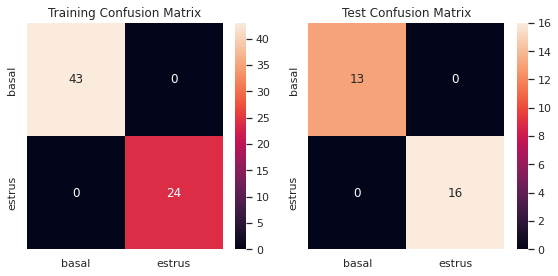

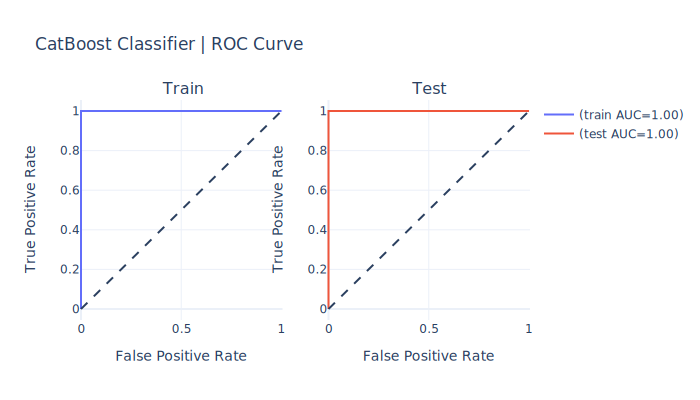

In [23]:
models = []
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))

model_eval(molten_ohe,
           clf=models[0],
           clf_name='model1',
           show_id=['roc','conf'])

### **SUMMARY : <span style='color:#94D4F6'>MODEL 1</span>**

<div style=" background-color:#94D4F6; padding: 8px 0px; border-radius: 8px; color: white">
    
<ul>
    <li>Well, it's quite conclusive that the model can very easily distinguish between the two phases very easily for different kind of cat species <b>basal,estrus</b>) from the <b>serum</b> subset</li>
    <li>Given enough data, a human can quite easily distinguish between the two phases, as the elevated estradiol levels were clearly visible during the estrus phase (<b>Section 3</b>)</li>
    <li>So creating a model to distinguish between <b>basal</b> & <b>estrus</b> phases is not really necessary and more importantly, there are other phases of an estrous cycle that need to be taken into account, as estradiol levels are also elevated during these phases and if we didn't have an expert define that these elevated levels were during the estrus phase, we could easily have mistaken them for diestrus and so on.</li>
</ul>
</div>

#### <b><span style='color:#94D4F6'>❯❯❯ SERUM </span> MODEL 2: <span style='color:#94D4F6'>BASAL</span></b> | **<span style='color:#94D4F6'>NPLP</span>** | **<span style='color:#94D4F6'>PLP CLASSIFICATION</span>**

For the second model:

- Using **<span style='color:#94D4F6'>serum</span>** data again, but this time we turn our attention to **<span style='color:#94D4F6'>prograsterone</span>** concentrations in circulating blood.
- For the second model, we'll be using the **<span style='color:#94D4F6'>prograsterone</span>** data obtained from serum & create a model that can classify between three states this time (**<span style='color:#94D4F6'>basal</span>**, **<span style='color:#94D4F6'>nplp</span>** & **<span style='color:#94D4F6'>plp</span>**)

In [24]:
# Select the relevant data
upd2 = feline_progest.iloc[:,pd.np.r_[0:2, 8:17]]
upd2.head()

,linage,species,p-basalmean,p-basalmin,p-basalmax,p-nplpmean,p-nplpmin,p-nplpmax,p-plpmean,p-plpmin,p-plpmax
0,Domestic cat,Domestic cat,1.0,NaN,NaN,25.8,NaN,NaN,NaN,NaN,NaN
1,Domestic cat,Domestic cat,0.5,NaN,NaN,24.6,19.0,31.0,34.9,29.0,41.0
2,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Domestic cat,Domestic cat,0.2,0.1,0.3,17.2,9.0,25.0,NaN,NaN,NaN
4,Domestic cat,Domestic cat,0.5,NaN,NaN,NaN,30.9,87.8,NaN,NaN,NaN


In [25]:
# melt but keep some column values 
molten = pd.melt(upd2,
                id_vars=['linage','species'])

molten.loc[(molten['variable'] == 'p-basalmean') |
           (molten['variable'] == 'p-basalmin') |
           (molten['variable'] == 'p-basalmax')
           , 'id'] = 'basal'
molten.loc[(molten['variable'] == 'p-nplpmean') |
           (molten['variable'] == 'p-nplpmin') |
           (molten['variable'] == 'p-nplpmax')
           , 'id'] = 'nplp'
molten.loc[(molten['variable'] == 'p-plpmean') |
           (molten['variable'] == 'p-plpmin') |
           (molten['variable'] == 'p-plpmax')
           , 'id'] = 'plp'

In [26]:
molten.dropna(inplace=True)
molten_ohe = pd.get_dummies(molten,columns=['linage','species','variable'])
molten_ohe

,value,id,linage_Domestic cat,linage_Lynx,linage_Ocelot,linage_Panthera,linage_Puma,species_Bobcat,species_Cheetah,species_Clouded leopard,species_Domestic cat,species_Eurasian lynx,species_Iberian lynx,species_Jagaurondi,species_Jaguar,species_Leopard,species_Lion,species_Ocelot,species_Puma,species_Snow leopard,species_Tigers,variable_p-basalmax,variable_p-basalmean,variable_p-basalmin,variable_p-nplpmax,variable_p-nplpmean,variable_p-nplpmin,variable_p-plpmax,variable_p-plpmean,variable_p-plpmin
0,1.0,basal,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.5,basal,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.2,basal,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.5,basal,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0.5,basal,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,30.0,plp,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
892,39.9,plp,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
930,27.1,plp,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
932,74.4,plp,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Training Samples: 94
Test Samples: 41


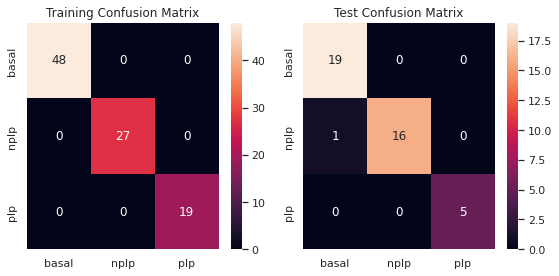

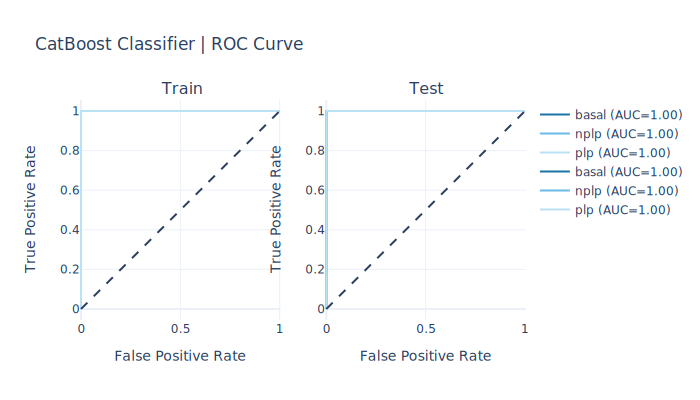

In [27]:
models = []
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))

model_eval(molten_ohe,
           clf=models[0],
           clf_name='model2',
           classif_id='multi',
           show_id=['roc','conf'])

### **SUMMARY : <span style='color:#94D4F6'>MODEL 2</span>**


<div style=" background-color:#94D4F6; padding: 8px 0px; border-radius: 8px; color: white">
    
<ul>
    <li>From the results we can see that the <b>CatBoost</b> model can quite easily distinguish between the three phases (<b>basal</b>,<b>nplp</b> & <b>plp</b>), as seen in the confusion matrix for both training & test sets, there are no false positives, which is very encouraging for the multiclass classifier.</li>
    <li>Whilst it may seem that using ohe for each combination may be too farfetched which boosts the models performance, it worth mentioning that it's not really understood why there is such a large variation of inconsistencies in data entries among all the data sources. Nevertheless, it's probably worth keeping these options (min,mean,max) as we might have obtain new data in a similar format</li>
</ul>
</div>

#### **<span style='color:#94D4F6'>❯❯❯ FECAL</span> MODEL 3 : <span style='color:#94D4F6'>BASAL</span> | <span style='color:#94D4F6'>ESTRUS CLASSIFICATION</span>**

For the third model:
- We'll be using only the **<span style='color:#94D4F6'>fecal</span>** data this time for **<span style='color:#94D4F6'>estradiol</span>** measurements (**<span style='color:#94D4F6'>fem</span>**)
- As with model 1, we'll be making a binary classifier to distinguish between **<span style='color:#94D4F6'>basal</span>** & **<span style='color:#94D4F6'>estrus</span>** phases

In [28]:
upd3 = feline_progest.iloc[:,pd.np.r_[0:2, 17:23]]
upd3.head()

,linage,species,fem-basalmean,fem-basalmin,fem-basalmax,fem-estrusmean,fem-estrusmin,fem-estrusmax
0,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN
1,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN
2,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN
3,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN
4,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# melt but keep some column values 
molten = pd.melt(upd3,
                id_vars=['linage','species'])

molten.loc[(molten['variable'] == 'fem-basalmean') |
           (molten['variable'] == 'fem-basalmin') |
           (molten['variable'] == 'fem-basalmax')
           , 'id'] = 'basal'
molten.loc[(molten['variable'] == 'fem-estrusmean') |
           (molten['variable'] == 'fem-estrusmin') |
           (molten['variable'] == 'fem-estrusmax')
           , 'id'] = 'estrus'

molten.dropna(inplace=True)
molten_ohe = pd.get_dummies(molten,columns=['linage','species','variable'])

In [30]:
molten.dropna(inplace=True)
molten_ohe = pd.get_dummies(molten,columns=['linage','species','variable'])
molten_ohe

,value,id,linage_Bay cat,linage_Caracal,linage_Domestic cat,linage_Leopard cat,linage_Lynx,linage_Ocelot,linage_Panthera,linage_Puma,species_Asiatic golden cat,species_Black footed cat,species_Canadian lynx,species_Caracal,species_Cheetah,species_Clouded leopard,species_Domestic cat,species_Fishing cat,species_Jaguar,species_Leopard,species_Leopard cat,species_Lion,species_Margay,species_Pallas cat,species_Snow leopard,species_Tigers,species_tigrina,variable_fem-basalmax,variable_fem-basalmean,variable_fem-basalmin,variable_fem-estrusmax,variable_fem-estrusmean,variable_fem-estrusmin
16,134.0,basal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
17,127.1,basal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
18,34.3,basal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
22,38.2,basal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
23,40.0,basal,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,2031.0,estrus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
649,15980.0,estrus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
650,2293.0,estrus,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
651,250.0,estrus,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Training Samples: 158
Test Samples: 68


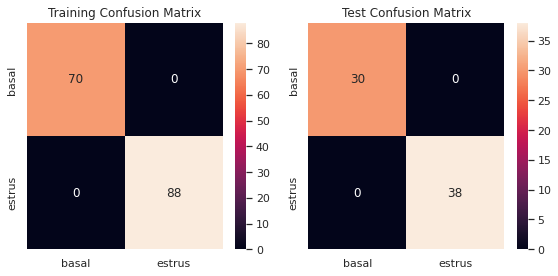

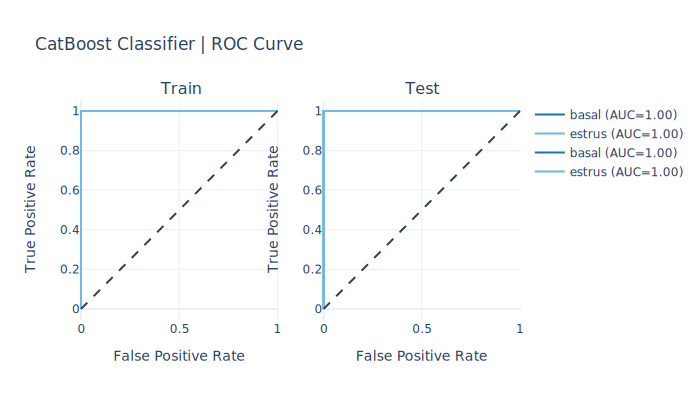

In [31]:
models = []
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))

model_eval(molten_ohe,
           clf=models[0],
           clf_name='model3',
           classif_id='multi',
           show_id=['roc','conf'])

### **SUMMARY : <span style='color:#94D4F6'>MODEL 3</span>** 

<div style=" background-color:#94D4F6; padding: 8px 0px; border-radius: 8px; color: white">
    
<ul>
    <li>As with model 1, it's quite straighforward for the model to distringuish between both classes, which was expected as a human can do this as well</li>

</ul>
</div>

#### <b><span style='color:#94D4F6'>❯❯❯ FECAL </span> MODEL 4: <span style='color:#94D4F6'>BASAL</span></b> | **<span style='color:#94D4F6'>NPLP</span>** | **<span style='color:#94D4F6'>PLP CLASSIFICATION</span>**

For the fourth model:

- Using **<span style='color:#94D4F6'>fecal</span>** data this time, we turn our attention to **<span style='color:#94D4F6'>prograsterone</span>** (**<span style='color:#94D4F6'>fem</span>**) concentrations extracted from fecies
- As with the second model we want to create a model that can classify between three states this time (**<span style='color:#94D4F6'>basal</span>**, **<span style='color:#94D4F6'>nplp</span>** & **<span style='color:#94D4F6'>plp</span>**)
- As was seen in the **<span style='color:#94D4F6'>serum</span>** model, the subtle difference in **<span style='color:#94D4F6'>progasterone</span>** levels can cause some issues for the model

In [32]:
upd4 = feline_progest.iloc[:,pd.np.r_[0:2, 23:32]]
upd4.head()

,linage,species,fpm-basalmean,fpm-basalmin,fpm-basalmax,fpm-nplpmean,fpm-nplpmin,fpm-nplpmax,fpm-plpmean,fpm-plpmin,fpm-plpmax
0,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Domestic cat,Domestic cat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# melt but keep some column values 
molten = pd.melt(upd4,
                id_vars=['linage','species'])

molten.loc[(molten['variable'] == 'fpm-basalmean') |
           (molten['variable'] == 'fpm-basalmin') |
           (molten['variable'] == 'fpm-basalmax')
           , 'id'] = 'basal'
molten.loc[(molten['variable'] == 'fpm-nplpmean') |
           (molten['variable'] == 'fpm-nplpmin') |
           (molten['variable'] == 'fpm-nplpmax')
           , 'id'] = 'nplp'
molten.loc[(molten['variable'] == 'fpm-plpmean') |
           (molten['variable'] == 'fpm-plpmin') |
           (molten['variable'] == 'fpm-plpmax')
           , 'id'] = 'plp'

In [34]:
molten.dropna(inplace=True)
molten_ohe = pd.get_dummies(molten,columns=['linage','species','variable'])
molten_ohe

,value,id,linage_Caracal,linage_Domestic cat,linage_Leopard cat,linage_Lynx,linage_Ocelot,linage_Panthera,linage_Puma,species_Black footed cat,species_Canadian lynx,species_Caracal,species_Cheetah,species_Clouded leopard,species_Domestic cat,species_Fishing cat,species_Jaguar,species_Leopard,species_Leopard cat,species_Lion,species_Margay,species_Pallas cat,species_Puma,species_Snow leopard,species_Tigers,species_tigrina,variable_fpm-basalmax,variable_fpm-basalmean,variable_fpm-basalmin,variable_fpm-nplpmax,variable_fpm-nplpmean,variable_fpm-nplpmin,variable_fpm-plpmax,variable_fpm-plpmean,variable_fpm-plpmin
16,10.1,basal,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
17,9.1,basal,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
18,20.3,basal,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
22,2.8,basal,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
23,2.6,basal,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,28.7,plp,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
976,40.6,plp,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
977,13.8,plp,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
978,345.0,plp,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Training Samples: 195
Test Samples: 84


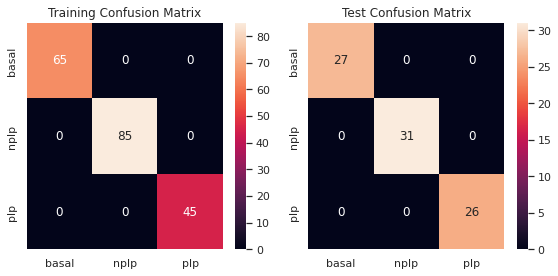

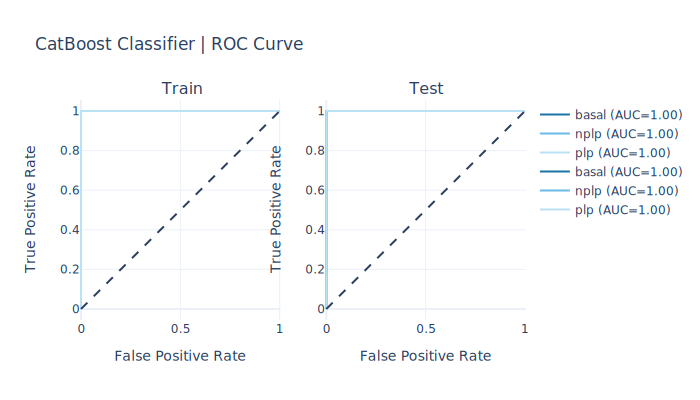

In [35]:
models = []
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))

model_eval(molten_ohe,
           clf=models[0],
           clf_name='model4',
           classif_id='multi',
           show_id=['roc','conf'])

### **SUMMARY : <span style='color:#94D4F6'>MODEL 4</span>**

<div style=" background-color:#94D4F6; padding: 8px 0px; border-radius: 8px; color: white">
    
<ul>
    <li>Similar to model 2, the <b>fecal</b> model performs quite well, being able to distinguish between <b>nplp</b> and <b>plp</b> phases quite well
</li>
</ul>
</div>

### <b><span style='color:#94D4F6;text-align:center'>❯❯ </span>UNIFIED MODELS</b>

#### <b><span style='color:#94D4F6'>❯❯❯ UNIFIED </span> MODEL 5: <span style='color:#94D4F6'>BASAL</span></b> | **<span style='color:#94D4F6'>NPLP</span>** | **<span style='color:#94D4F6'>PLP CLASSIFICATION</span>**

### **<span style='color:#94D4F6'>MAIN MODEL </span>**

For the fifth model:
- We'll combine both **<span style='color:#94D4F6'>serum</span>** and **<span style='color:#94D4F6'>fecal</span>** data, this leads to 414 rows of data, which is quite a bit more data
- As noted noted in **<span style='color:#94D4F6'>Section 2.1</span>** and we saw from the plots in **<span style='color:#94D4F6'>Section 3.5 & 3.6</span>**, the units are of course different and feature values differ quite substantially
- So it is more ideal to **<span style='color:#94D4F6'>standardise</span>** our data, something you can try yourself

In [36]:
# Select the relevant data
upd5 = feline_progest.iloc[:,pd.np.r_[0:2, 8:17,23:32]]

# melt but keep some column values 
molten5 = pd.melt(upd5,
                id_vars=['linage','species'])

molten5.loc[(molten5['variable'] == 'p-basalmean') |
           (molten5['variable'] == 'p-basalmin') |
           (molten5['variable'] == 'p-basalmax')
           , 'id'] = 'basal'
molten5.loc[(molten5['variable'] == 'p-nplpmean') |
           (molten5['variable'] == 'p-nplpmin') |
           (molten5['variable'] == 'p-nplpmax')
           , 'id'] = 'nplp'
molten5.loc[(molten5['variable'] == 'p-plpmean') |
           (molten5['variable'] == 'p-plpmin') |
           (molten5['variable'] == 'p-plpmax')
           , 'id'] = 'plp'

molten5.loc[(molten5['variable'] == 'fpm-basalmean') |
           (molten5['variable'] == 'fpm-basalmin') |
           (molten5['variable'] == 'fpm-basalmax')
           , 'id'] = 'basal'
molten5.loc[(molten5['variable'] == 'fpm-nplpmean') |
           (molten5['variable'] == 'fpm-nplpmin') |
           (molten5['variable'] == 'fpm-nplpmax')
           , 'id'] = 'nplp'
molten5.loc[(molten5['variable'] == 'fpm-plpmean') |
           (molten5['variable'] == 'fpm-plpmin') |
           (molten5['variable'] == 'fpm-plpmax')
           , 'id'] = 'plp'

molten5.dropna(inplace=True)
molten_ohe5 = pd.get_dummies(molten5,columns=['linage','species','variable'])
molten_ohe5.value = molten_ohe5.value.astype('float')
molten_ohe5

,value,id,linage_Caracal,linage_Domestic cat,linage_Leopard cat,linage_Lynx,linage_Ocelot,linage_Panthera,linage_Puma,species_Black footed cat,species_Bobcat,species_Canadian lynx,species_Caracal,species_Cheetah,species_Clouded leopard,species_Domestic cat,species_Eurasian lynx,species_Fishing cat,species_Iberian lynx,species_Jagaurondi,species_Jaguar,species_Leopard,species_Leopard cat,species_Lion,species_Margay,species_Ocelot,species_Pallas cat,species_Puma,species_Snow leopard,species_Tigers,species_tigrina,variable_fpm-basalmax,variable_fpm-basalmean,variable_fpm-basalmin,variable_fpm-nplpmax,variable_fpm-nplpmean,variable_fpm-nplpmin,variable_fpm-plpmax,variable_fpm-plpmean,variable_fpm-plpmin,variable_p-basalmax,variable_p-basalmean,variable_p-basalmin,variable_p-nplpmax,variable_p-nplpmean,variable_p-nplpmin,variable_p-plpmax,variable_p-plpmean,variable_p-plpmin
0,1.0,basal,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.5,basal,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.2,basal,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.5,basal,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0.5,basal,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1951,28.7,plp,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1957,40.6,plp,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1958,13.8,plp,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1959,345.0,plp,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Training Samples: 289
Test Samples: 125


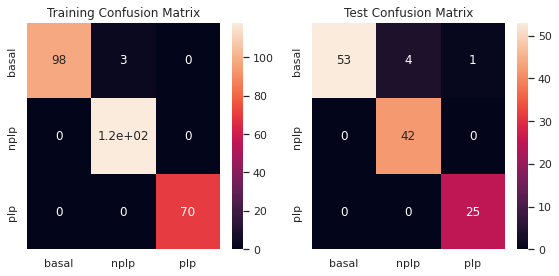

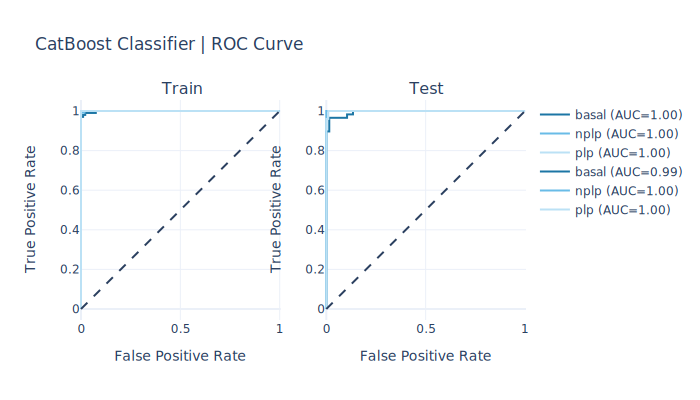

In [37]:
models = []
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))

model_eval(molten_ohe5,
           clf=models[0],
           clf_name='model5',
           classif_id='multi',
           show_id=['roc','conf'])

In [38]:
from sklearn.feature_selection import SelectKBest,f_regression
from xgboost import plot_importance,XGBRegressor
from catboost import CatBoostClassifier,CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import shap
import seaborn as sns

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Plot Correlation to Target Variable only
def corrMat(df,target='id',figsize=(9,0.5),ret_id=False):
    
    corr_mat = df.corr().round(2)
    shape = corr_mat.shape[0]
    corr_mat = corr_mat.transpose()
    corr = corr_mat.loc[:, df.columns == target].transpose().copy()
    
    if(ret_id):
        return corr

''' Feature Importance '''
# Various Approaches for quick FI evaluation

def fi(ldf,target='id',n_est=25,drop_id=None,target_cat=True):
    
    ldf = ldf.copy()
    # If target is categorical string variable
    if(target_cat):
        cats = ldf[target].unique()
        cats_id = [i for i in range(0,len(cats))]
        maps = dict(zip(cats,cats_id))    
        ldf[target] = ldf[target].map(maps)
    
    # If any features are desired to be droped 
    if(drop_id is not None):
        ldf = ldf.drop(drop_id,axis=1)

    # Input dataframe containing feature & target variable
    y = ldf[target]
    X = ldf.drop(target,axis=1)
    
#   CORRELATION
    imp = corrMat(ldf,target,figsize=(15,0.5),ret_id=True)
    del imp[target]
    s1 = imp.squeeze(axis=0);s1 = abs(s1)
    s1.name = 'CORR'
    
#   SHAP
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap_sum = np.abs(shap_values).mean(axis=0)
    s2 = pd.Series(shap_sum,index=X.columns,name='CAT_SHAP').T
    
#   CATBOOST
    model = CatBoostRegressor(silent=True,n_estimators=n_est).fit(X,y)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['CAT'])
    rf_fi.sort_values('CAT',ascending=False)
    s3 = rf_fi.T.squeeze(axis=0)
    
#   RANDOMFOREST
    model = RandomForestRegressor(n_est,random_state=0, n_jobs=-1)
    fit = model.fit(X,y)
    rf_fi = pd.DataFrame(model.feature_importances_,index=X.columns,
                                         columns=['RF'])
    rf_fi.sort_values('RF',ascending=False)
    s4 = rf_fi.T.squeeze(axis=0)

#   XGB 
    model=XGBRegressor(n_estimators=n_est,learning_rate=0.5,verbosity = 0)
    model.fit(X,y)
    data = model.feature_importances_
    s5 = pd.Series(data,index=X.columns,name='XGB').T

#   KBEST
    model = SelectKBest(k=5, score_func=f_regression)
    fit = model.fit(X,y)
    data = fit.scores_
    s6 = pd.Series(data,index=X.columns,name='KBEST')

    # Combine Scores
    df0 = pd.concat([s1,s2,s3,s4,s5,s6],axis=1)
    df0.rename(columns={'target':'lin corr'})

    # MinMax Scaler
    x = df0.values 
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled,index=df0.index,columns=df0.columns)
    df = df.rename_axis(f'<b>FI APPROACH</b>', axis=1)
    df = df.rename_axis('Feature', axis=0)
    
    pd.options.plotting.backend = "plotly"
    fig = df.plot(kind='bar',title='<b>SCALED FEATURE IMPORTANCE</b>',
                  color_discrete_sequence=px.colors.qualitative.T10)
    fig.update_layout(template='plotly_white',height=400,
                     font=dict(family='sans-serif',size=12),
                     margin=dict(l=60, r=40, t=50, b=10))
    fig.update_traces(width=0.85)
    fig.show('svg',dpi=300)

### **<span style='color:#94D4F6'>INSTANT RELATIVE FEATURE IMPORTANCE </span>**

- We can look at the <b>Feature Importance</b> (FI) of certain trained models to understand which features & to what extent.
- We can use such minimalistic functions to quicky evaluat feature importance by relying on <b>variation of approaches</b> & <b>optimised libraries</b>.
- We can obtain <b>relative feature importance</b> using different libraries , <b>function</b> <code>feature_importance</code> includes:

> - **<span style='color:#94D4F6'>Linear Correlation</span>** w/ abs() function.
> - **<span style='color:#94D4F6'>SHAP Values</span>** of Catboost Regression Model (n_est)
> - **<span style='color:#94D4F6'>RandomForest Regressor</span>** (n_est)
> - **<span style='color:#94D4F6'>XGBoost Regressor</span>** (n_est)
> - **<span style='color:#94D4F6'>CatBoost Regressor</span>** (n_est)
> - **<span style='color:#94D4F6'>SelectKBest</span>** (k)

### **<span style='color:#94D4F6'>POST MODEL ADJUSTMENT </span>**

- The indivual scores are combined and scaled using <code>MinMaxScaler()</code> & Plot.
- The y-axis represents the total score (higher score is better, max -> Number of approaches).
- The x-axis represents the corresponding features of input dataframe.

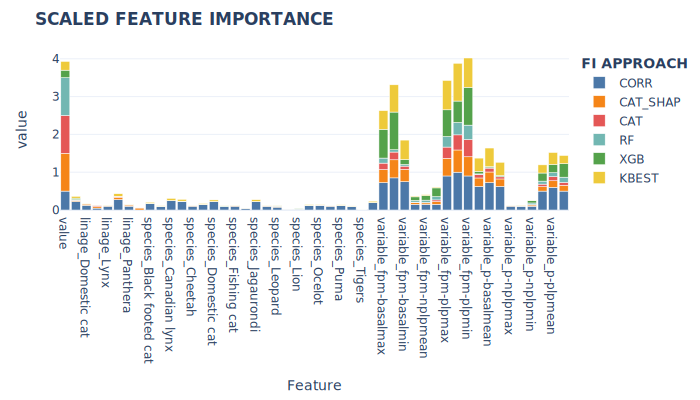

In [39]:
fi(molten_ohe5,target='id')

### **<span style='color:#94D4F6'>SPECIES-LINAGE MODEL </span>**
- If we rely only on using the **<span style='color:#94D4F6'>linage</span>**, **<span style='color:#94D4F6'>species</span>** & **<span style='color:#94D4F6'>progasterone</span>** values itself, the accuracy of the model drops quite significantly
- The model has difficulty correctly classifying between **<span style='color:#94D4F6'>nplp</span>** & **<span style='color:#94D4F6'>plp</span>** phases as can be seen by the multiclass ROC curves, as well as the confusion matrix


- So adding features relating to **<span style='color:#94D4F6'>fecal</span>** or **<span style='color:#94D4F6'>serum</span>** division data, as well as whether it is a **mean**, the **maximum case** or **minimum case** improves the model accuracy quite substantially because it provides an accurate picture of the data distribution in the multidimensional data, which is expected as CatBoost is quite an advanced model

Index(['value', 'id', 'linage_Caracal', 'linage_Domestic cat',
       'linage_Leopard cat', 'linage_Lynx', 'linage_Ocelot', 'linage_Panthera',
       'linage_Puma', 'species_Black footed cat', 'species_Bobcat ',
       'species_Canadian lynx', 'species_Caracal', 'species_Cheetah',
       'species_Clouded leopard', 'species_Domestic cat',
       'species_Eurasian lynx', 'species_Fishing cat ', 'species_Iberian lynx',
       'species_Jagaurondi', 'species_Jaguar', 'species_Leopard',
       'species_Leopard cat', 'species_Lion', 'species_Margay',
       'species_Ocelot ', 'species_Pallas cat ', 'species_Puma',
       'species_Snow leopard', 'species_Tigers', 'species_tigrina'],
      dtype='object')
Training Samples: 289
Test Samples: 125


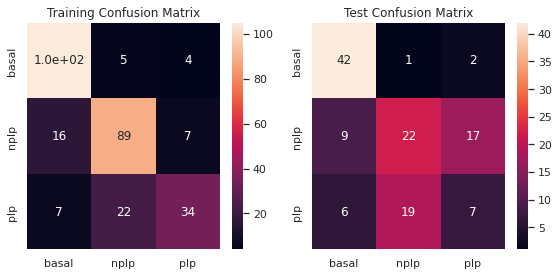

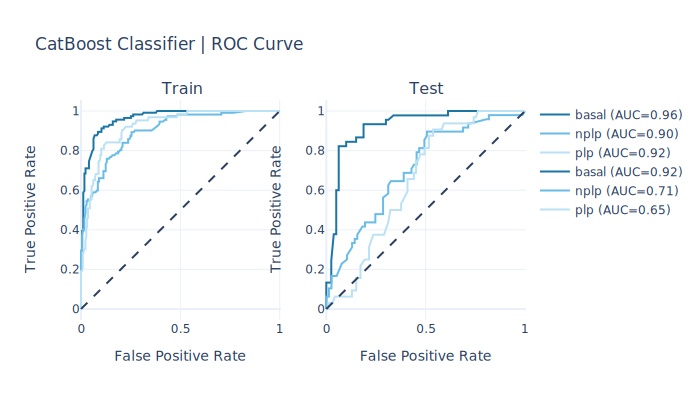

In [40]:
tmolten_ohe5 = molten_ohe5.iloc[:,0:31]
print(tmolten_ohe5.columns)

models = []
models.append(('CAT',CatBoostClassifier(silent=True,
                                        n_estimators=25)))

model_eval(tmolten_ohe5,
           clf=models[0],
           clf_name='tmodel5',
           classif_id='multi',
           show_id=['roc','conf'])

### **SUMMARY : <span style='color:#94D4F6'>MODEL 5</span>**

<div style=" background-color:#94D4F6; padding: 8px 0px; border-radius: 8px; color: white">
    
<ul>
    <li>Having combined two approaches that measure the levels of <b>progesterone</b> in both <b>serum</b> and <b>fecies</b>, we can note that the model can still classify quite well, which is quite nice, there are very few missclassified cases & the difference between <b>nplp</b> and <b>plp</b> phases is distinguished quite well</li>
    <li>On the other hand, the model doesn't seem to put emphasis on the variation in both <b>species</b> & <b>linage</b>, which is a shame, because in essence, it should be a key factor in the the variation of <b>progesterone</b> levels</li>
<li>The model obviously learns to recognise the mean, max & min patterns as well as the variation between <b>serum</b> & <b>fecal</b> data instead to construct an accurate model, so if we don't include this data, the accuracy of the model drop significantly, as the <b>species-linear model</b> demonstrated
    </li>

</ul>
</div>

<div style=" background-color:#17202a; padding: 30px 10px 30px; border-radius: 8px; color: white;padding-right: 200px; padding-left: 30px">
    
<b>❮ <span style='color:#94D4F6;text-align:right'>CONCLUSION</span> START ❯</b>
    
<ul>
    <li>Monitoring ovarian function and detecting pregnancy in felids is important for wild felines</li>
    <li>In this notebook, we focused on creating machine learning models that would classify the ovarian phase based on estradiol & progesterone levels</li>
    <li>We tried two different approaches (basal/estrus), (basal/nplp/plp) based on serum data, as well as fecal only data as well. These models performed very well, the machine learning model has no problem differentiating between the different classes.</li>
    <li>Both fecal and serum data were combined to test the above split groups again (basal,nplp,plp), where the models performed perfectly once again</li>
    <li>However when utilising linage data, we saw a dip in model accuracy, where plp and nplp phases were often missclassified</li>
   
</ul>
    
<b>❮ <span style='color:#94D4F6;text-align:right'>CONCLUSION</span> END ❯</b>
    
</div>